
🔧 Processing target: Total kVA
✅ MAE: 3097.12
✅ MAPE (unsafe): 3.42%
✅ MAPE (safe): 3.42%
✅ RMSE: 4276.42
✅ R2 Score: 0.91
✅ Accuracy (±5% band): 81.03%

🔧 Processing target: kVA - 132 L3
✅ MAE: 1327.42
✅ MAPE (unsafe): 3.85%
✅ MAPE (safe): 3.85%
✅ RMSE: 1821.99
✅ R2 Score: 0.87
✅ Accuracy (±5% band): 75.00%

🔧 Processing target: kVA - 132 L5
✅ MAE: 1334.35
✅ MAPE (unsafe): 3.87%
✅ MAPE (safe): 3.87%
✅ RMSE: 1828.83
✅ R2 Score: 0.87
✅ Accuracy (±5% band): 75.14%

🔧 Processing target: Total kVA - 132
✅ MAE: 2646.75
✅ MAPE (unsafe): 3.85%
✅ MAPE (safe): 3.85%
✅ RMSE: 3610.64
✅ R2 Score: 0.88
✅ Accuracy (±5% band): 75.11%


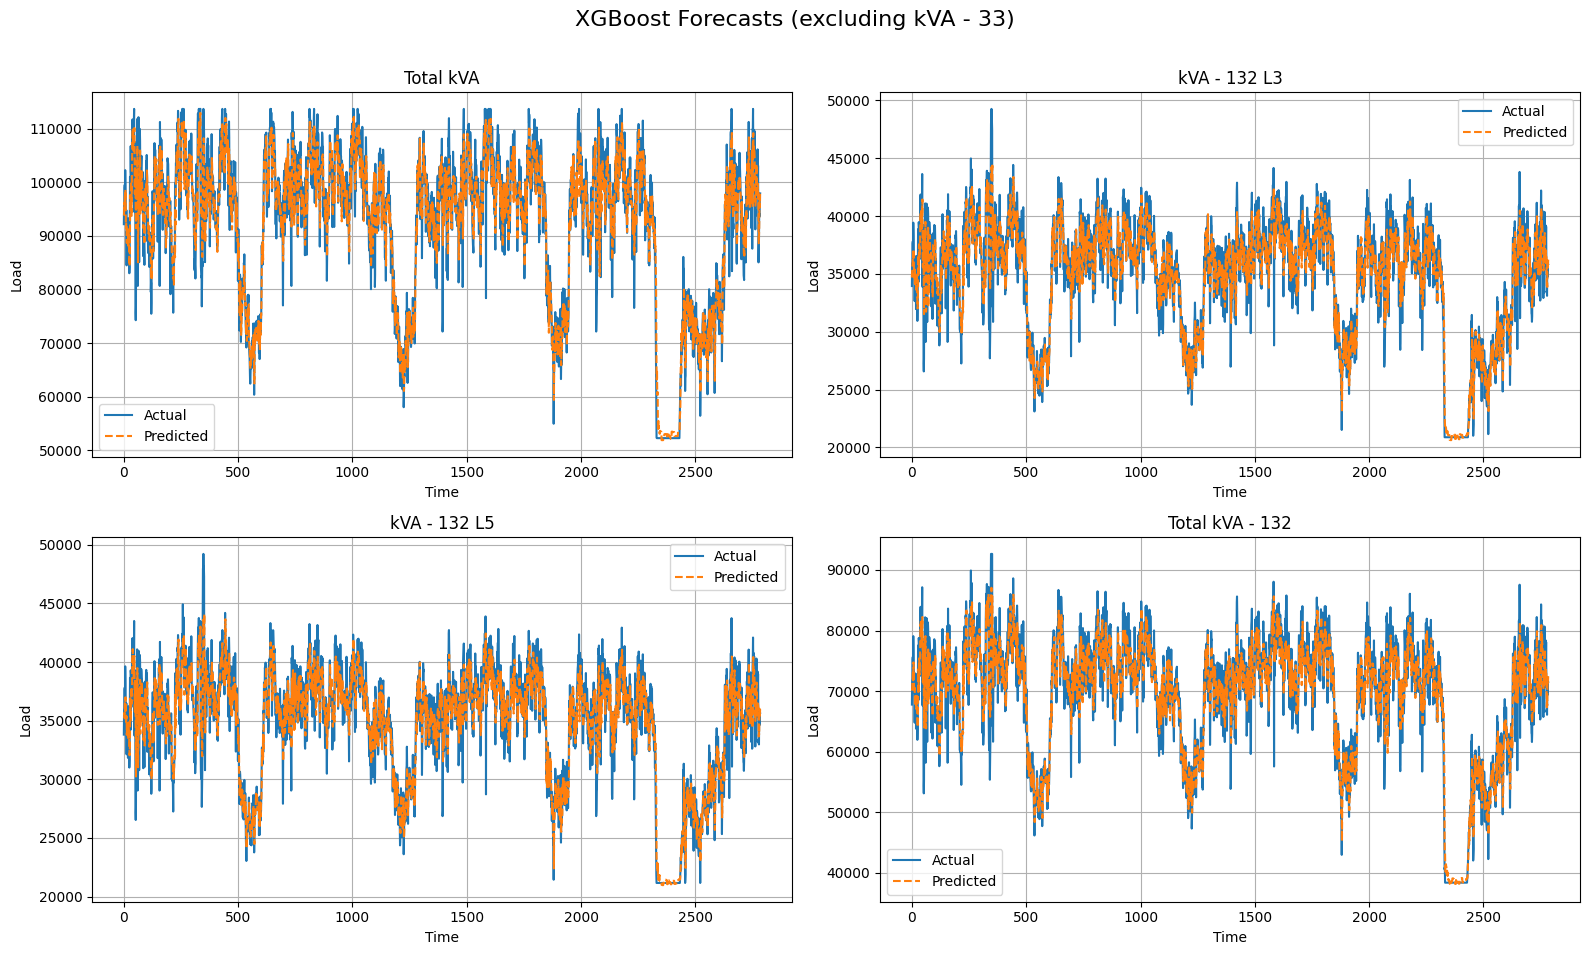

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data
df = pd.read_excel("/content/load all 3 lines.xlsx")
df['Date Time'] = pd.to_datetime(df['Date Time'])
df.set_index('Date Time', inplace=True)

# Define cutoff date for train/test split
cutoff = pd.to_datetime("2025-02-18")

# Get numeric columns only, excluding "kVA - 33"
target_columns = df.select_dtypes(include=[np.number]).columns
target_columns = [col for col in target_columns if col != "kVA - 33"]

# Set up multi-plot figure
n_cols = 2
n_rows = int(np.ceil(len(target_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

# Process each target column
for i, target_col in enumerate(target_columns):
    print(f"\n🔧 Processing target: {target_col}")

    df_temp = df.copy()
    df_temp['load'] = df_temp[target_col]

    # Clip load
    load_min = df_temp['load'].min()
    load_max = df_temp['load'].max()
    lower_bound = load_min + 0.25 * (load_max - load_min)
    upper_bound = load_min + 0.85 * (load_max - load_min)
    df_temp['load'] = df_temp['load'].clip(lower=lower_bound, upper=upper_bound)

    # Time-based features
    df_temp['hour'] = df_temp.index.hour
    df_temp['dayofweek'] = df_temp.index.dayofweek
    df_temp['is_weekend'] = df_temp['dayofweek'].isin([5, 6]).astype(int)

    # Lag features
    for lag in [1, 2, 4, 8, 16]:
        df_temp[f'lag_{lag}'] = df_temp['load'].shift(lag)

    # Rolling mean
    df_temp['rolling_mean_4h'] = df_temp['load'].rolling(16).mean()

    # Drop NaNs
    df_temp.dropna(inplace=True)

    # Split
    train = df_temp[df_temp.index < cutoff]
    test = df_temp[df_temp.index >= cutoff]

    features = ['hour', 'dayofweek', 'is_weekend'] + \
               [f'lag_{l}' for l in [1, 2, 4, 8, 16]] + ['rolling_mean_4h']

    X_train = train[features]
    y_train = train['load']
    X_test = test[features]
    y_test = test['load']

    # Train model
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    safe_mape = np.mean(np.abs((y_test[y_test != 0] - y_pred[y_test != 0]) / y_test[y_test != 0])) * 100
    band_accuracy = ((y_pred >= y_test * 0.9475) & (y_pred <= y_test * 1.0525)).mean() * 100

    # Print metrics
    print(f"✅ MAE: {mae:.2f}")
    print(f"✅ MAPE (unsafe): {mape:.2f}%")
    print(f"✅ MAPE (safe): {safe_mape:.2f}%")
    print(f"✅ RMSE: {rmse:.2f}")
    print(f"✅ R2 Score: {r2:.2f}")
    print(f"✅ Accuracy (±5% band): {band_accuracy:.2f}%")

    # Plot
    ax = axes[i]
    ax.plot(y_test.values, label='Actual')
    ax.plot(y_pred, label='Predicted', linestyle='--')
    ax.set_title(f"{target_col}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Load")
    ax.legend()
    ax.grid(True)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("XGBoost Forecasts (excluding kVA - 33)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
